오늘 배운 개념들에 해당하는 코드들을 다른 데이터에 적용해보세요!
(여러분이 궁금한 데이터면 좋습니다. 물론 breast cancer, iris 등도 가능)

1. 그 데이터에 대한 두 개 이상의 분류 모델의 AUC를 비교해 더 좋은 모델 한가지를 선택해주세요. (ROC, PR 곡선 중 데이터에 더 적합한 기준 선택)
2. 선택된 모델에 대해 K-fold Cross validation을 통한 Grid search를 시행해 최적의 파라미터를 도출하고 그 때의 score도 구해주세요.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection as skms, linear_model, metrics, neighbors
import warnings
warnings.filterwarnings(action='ignore')
import seaborn as sns

Session 7에서 사용한 Airbnb 데이터를 사용하겠습니다!

### 1. 데이터 전처리

In [2]:
df = pd.read_csv("AB_NYC_2019.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [6]:
# 브루클린, 맨하튼 숙소만
our_set = df[df['neighbourhood_group'].isin(['Brooklyn', 'Manhattan'])]

#room type -> onehot 인코딩
#중요한 변수 선택

onehot = pd.get_dummies(our_set['room_type'])
core_cols = our_set[['neighbourhood_group', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']]
combined = core_cols.merge(onehot, left_index=True, right_index=True, how='left').reset_index()

In [7]:
#Brooklyn 을 0, Manhattan을 1로 코딩
final = combined.drop(columns=['index']).dropna()
final = final.replace('Brooklyn', 0).replace('Manhattan', 1)
final.head()

,neighbourhood_group,price,minimum_nights,number_of_reviews,reviews_per_month,Entire home/apt,Private room,Shared room
0,0,149,1,9,0.21,0,1,0
1,1,225,1,45,0.38,1,0,0
3,0,89,1,270,4.64,1,0,0
4,1,80,10,9,0.10,1,0,0
5,1,200,3,74,0.59,1,0,0


### 2-1. Decision Tree

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

In [9]:
X = final[['price','minimum_nights','number_of_reviews','reviews_per_month','Entire home/apt','Private room','Shared room']]
y = final['neighbourhood_group']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 10)

In [11]:
#Session 7 Quest 결과 max_depth 가 6일 때 가장 좋은 성능을 보여줬다.
dt = tree.DecisionTreeClassifier(max_depth = 6, random_state = 10)
dt.fit(X_train,y_train)

print('train set score {:3f}'.format(dt.score(X_train,y_train)))
print('test set score {:3f}'.format(dt.score(X_test,y_test)))

train set score 0.665193
test set score 0.668682


Text(51.0, 0.5, 'actual')

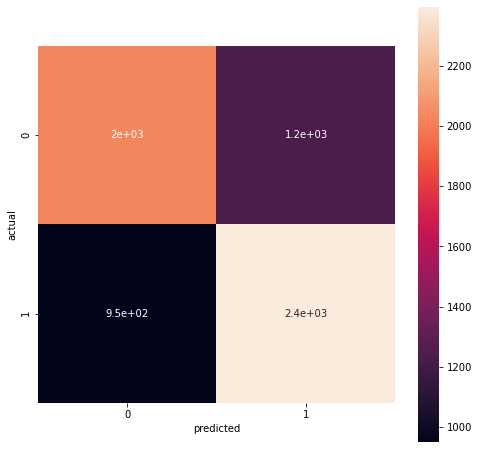

In [12]:
dt_preds = (dt.fit(X_train,y_train).predict(X_test))

fig, ax = plt.subplots(1,1,figsize=(8,8))
cm = metrics.confusion_matrix(y_test, dt_preds)
ax = sns.heatmap(cm, annot=True, square=True)
ax.set_xlabel('predicted')
ax.set_ylabel('actual')

> Manhatten의 숙소를 Brooklyn의 숙소보다 더 잘 분류하는 경향이 있다.

### 2-2. KNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier

#Session7 Quest 결과 K=41일 때 성능이 가장 좋았다.
knn = KNeighborsClassifier(n_neighbors = 41, n_jobs = -1, p=2, leaf_size =30)
knn.fit(X_train, y_train.values.ravel())
knn.score(X_train, y_train)

print('train set score {:3f}'.format(knn.score(X_train, y_train)))
print('test set score {:3f}'.format(knn.score(X_test, y_test)))

train set score 0.650077
test set score 0.637243


Text(51.0, 0.5, 'actual')

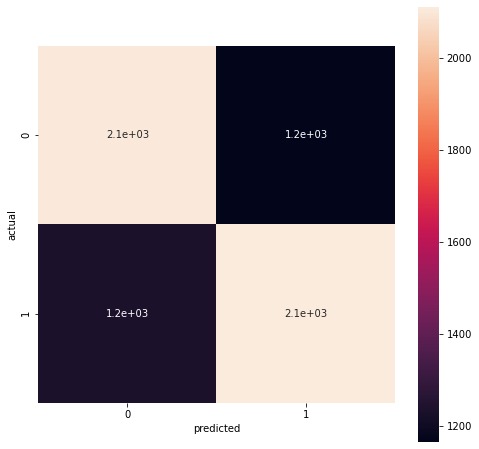

In [18]:
knn_preds = (knn.fit(X_train,y_train).predict(X_test))

fig, ax = plt.subplots(1,1,figsize=(8,8))
cm = metrics.confusion_matrix(y_test, knn_preds)
ax = sns.heatmap(cm, annot=True, square=True)
ax.set_xlabel('predicted')
ax.set_ylabel('actual')

> Decision Tree에 비해 Brooklyn의 숙소도 잘 분류하는 것처럼 보인다.

### 3. ROC Curve

[0.        0.3795107 1.       ]
[0.         0.71578004 1.        ]
[2 1 0]


Text(0.5, 1.0, 'Decision Tree ROC Curve\nAUC:0.668')

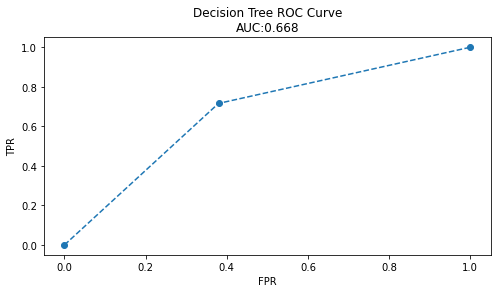

In [19]:
#Decision Tree 모델

fpr, tpr, ths = metrics.roc_curve(y_test, dt_preds)
print(fpr)
print(tpr)
print(ths)

auc = metrics.auc(fpr, tpr)

fig = plt.figure(figsize=(8,4))
plt.plot(fpr,tpr, 'o--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Decision Tree ROC Curve\nAUC:{:.3f}'.format(auc))

[0.         0.35626911 1.        ]
[0.         0.63090257 1.        ]
[2 1 0]


Text(0.5, 1.0, 'KNN ROC Curve\nAUC:0.637')

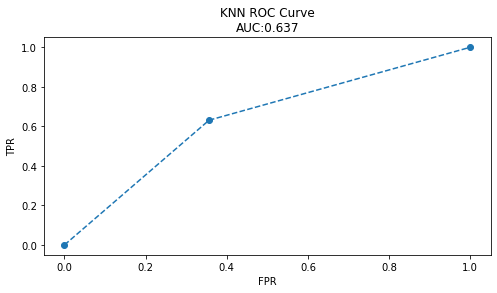

In [20]:
#KNN 모델

fpr, tpr, ths = metrics.roc_curve(y_test, knn_preds)
print(fpr)
print(tpr)
print(ths)

auc = metrics.auc(fpr, tpr)

fig = plt.figure(figsize=(8,4))
plt.plot(fpr,tpr, 'o--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('KNN ROC Curve\nAUC:{:.3f}'.format(auc))

> AUC 비교 결과 Decision Tree의 AUC가 더 높게 나오므로 더 좋은 모델이라고 할 수 있다!    
Decision Tree: 0.668 / KNN: 0.637    
Confusion Matrix로 확인한 결과와는 살짝 다르게 나온다...

### 4. K-fold Cross validation을 통한 Grid search

In [38]:
dt = tree.DecisionTreeClassifier()

param_grid = {'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9]}
grid_model = skms.GridSearchCV(dt, param_grid = param_grid)

grid_model.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=10),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9]})

In [39]:
print("최적의 파라미터", grid_model.best_params_)
print("최고 점수", grid_model.best_score_)

최적의 파라미터 {'max_depth': 7}
최고 점수 0.6572571854696494


In [40]:
df = pd.DataFrame(grid_model.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.017950,0.004035,0.002795,0.000749,2,{'max_depth': 2},0.621954,0.610051,0.609862,0.612812,0.616402,0.614216,0.004537,8
1,0.020744,0.002309,0.003791,0.000746,3,{'max_depth': 3},0.634423,0.634234,0.642925,0.636054,0.650038,0.639535,0.006134,7
2,0.024733,0.002918,0.002993,0.000631,4,{'max_depth': 4},0.650104,0.650860,0.653505,0.650227,0.666289,0.654197,0.006170,6
3,0.027737,0.002906,0.002793,0.000399,5,{'max_depth': 5},0.655961,0.650671,0.651049,0.649093,0.665533,0.654461,0.005994,5
4,0.029911,0.002083,0.003188,0.000401,6,{'max_depth': 6},0.659172,0.660495,0.651615,0.654006,0.655518,0.656161,0.003273,3
5,0.032512,0.000488,0.002793,0.000399,7,{'max_depth': 7},0.660495,0.660306,0.654071,0.653061,0.658352,0.657257,0.003122,1
6,0.038696,0.007090,0.003392,0.000489,8,{'max_depth': 8},0.655772,0.655394,0.646703,0.651361,0.673091,0.656464,0.008938,2
7,0.045890,0.006668,0.003989,0.001545,9,{'max_depth': 9},0.650860,0.649537,0.647648,0.654762,0.669879,0.654537,0.008018,4


In [41]:
df[['param_max_depth', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_max_depth,mean_test_score,std_test_score,rank_test_score
0,2,0.614216,0.004537,8
1,3,0.639535,0.006134,7
2,4,0.654197,0.006170,6
3,5,0.654461,0.005994,5
4,6,0.656161,0.003273,3
5,7,0.657257,0.003122,1
6,8,0.656464,0.008938,2
7,9,0.654537,0.008018,4


> Grid Search 결과 max_depth는 7로 앞서 구했던 max_depth=6과 살짝 다르게 나왔다.